In [192]:
from os import listdir,path,walk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from datetime import date

from scipy.interpolate import UnivariateSpline,interp1d 
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.optimize import fsolve
import lmfit as lm
import scipy.stats as stats


mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.linewidth'] = 1.5
pd.options.display.float_format = '{:,.4f}'.format
colors = {"Sec2_GFP":"brown","WT":"b","Sec9_GFP":"orange","Sec18_AA":"purple"}


# SMLM Classification / Copy number / Averaging

In [166]:
#---Simulation dataset----
#------File containing the geometrical features for the synthetic sites
geom_params  = pd.read_csv("/home/jsortiz/phd/Beta-Fitting/Geom_params_data_Simulate_Rings_Nfold_Rv_15_50_Nexos_6_8_ForPaper.csv")
#------File containing the localization coordinates for each synthetic sites
simul_params = pd.read_csv("/home/jsortiz/phd/Beta-Fitting/All_data_Simulate_Rings_Nfold_Rv_15_50_Nexos_6_8_ForPaper.csv")
#-------------------------

#---Experimetan dataset----
#------File containing the geometrical features for the experimental sites
#------Datasets: Exo-mM-GFP, Exo-mM/Sec2-GFP, Exo-mM/Sec9-GFP, Exo-mM-GFP (Sec18_AA)
exp_params = pd.read_csv("/home/jsortiz/phd/Beta-Fitting/Feature_Experimental_Dataset_Classified.csv")
#-------------------------

##  Fig S4: Comparing Rg with Spots and Rings

'fig = plt.figure()\nb = sns.color_palette("Greys",5,as_cmap=False)\nsns.heatmap([[0,0],[1,1]],cmap=b)\n#plt.colorbar()\nplt.savefig("figs/color_bar.svg")\n'

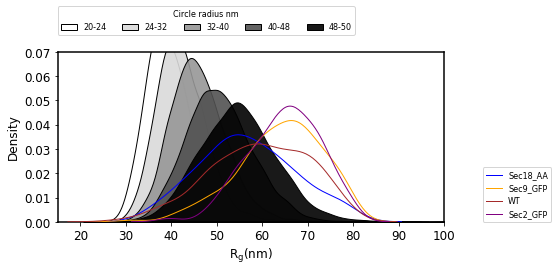

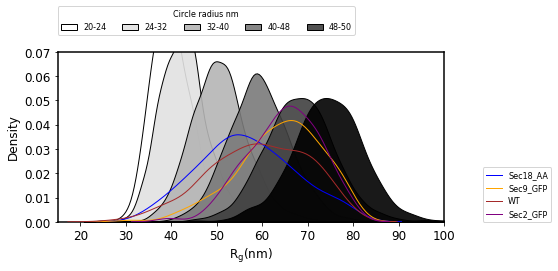

In [8]:
sets= ["Sec2_GFP","WT","Sec9_GFP","Sec18_AA"]

sets_names = {"WT": "Exocyst-mM-GFP",
              "Sec2_GFP": "Exocyst-mM/Sec2-GFP",
              "Sec9_GFP": "Exocyst-mM/Sec9-GFP",
              "Sec18_AA": "Exocyst-mM-GFP/Sec18-FRB"}

for idM in ["Spot","Ring"]:
    
    if idM == "Ring":        
        geom_params = pd.read_csv("Geom_params_data_Simulate_Rings_Nfold_Rv_15_50_Nexos_6_8_ForPaper.csv")
    elif idM == "Spot":
        geom_params = pd.read_csv("Geom_params_data_Simulate_Spots_Rv_8_50_Nexos_6_8_ForPaper.csv") 
    else:
        break                   
                                  
    geom_params = geom_params.query("Rv>15").copy()
    
    plt.figure(figsize=(8,4))

    geom_params["Model"] = geom_params["Rv"]//8
    
    sns.kdeplot(data=geom_params,x="R_2nd",hue=-geom_params["Model"],
                common_norm=False,fill=True,alpha=.9,palette='Greys_r',lw=1.,cbar=True,edgecolor='k')  
    
    plt.legend(["20-24","24-32", "32-40","40-48", "48-50"],
        loc=[.0,1.1],title="Circle radius nm",ncol=5,fontsize=8,title_fontsize=8)
    plt.xlim(15,100)
    plt.ylim(0,0.07)
    plt.xlabel("$\mathrm{R_g (nm)}$")

    ax2 = plt.twinx()  
    sns.kdeplot(data=exp_params,hue="Set",x="R_2nd",common_norm=False,palette=colors,lw=1.,ax=ax2)
    
    ax2.set_xlim(15,100)
    ax2.set_ylim(0,0.07)
    ax2.legend(np.flip(sets),loc=[1.1,0],fontsize=8)    
    ax2.set_axis_off()    
    
    
    plt.tight_layout()

    
    #plt.savefig("figs/Paper_Figures/Comparing_%s_WT.png"%idM,dpi=80,facecolor='white')

"""fig = plt.figure()
b = sns.color_palette("Greys",5,as_cmap=False)
sns.heatmap([[0,0],[1,1]],cmap=b)
#plt.colorbar()
plt.savefig("figs/color_bar.svg")
"""

In [ ]:
plt.plot(d)

## Fig S8C:  SMLM Copy number

### Functions

In [129]:
def errn_stan(x_tar,x_ref,nref):    
    
    x  = np.mean(x_tar)    
    y  = np.mean(x_ref)    
    
    nx = len(x_tar)
    ny = len(x_ref)
    
    sx = np.std(x_tar)     
    sy = np.std(x_ref)     
    
    n    = x/y*nref
    sn   = n*np.sqrt(sx**2/x**2+sy**2/y**2)
    
    return(n,sn)

def denplot(locs,xshift,ax=plt,style=1,**kwargs):    
    #+++++++++++++++Log-normal kernel++++++++++++++++++++++++++++            
    fit = stats.lognorm.fit(locs,floc=0)    
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++     
    xs  = np.arange(locs.min()-2,locs.max()+2)
    y   = stats.lognorm.pdf(xs,fit[0],loc=0,scale=fit[2])
    norm= np.max(y)/0.45
    y   = y/norm   
    #plt.plot(xshift+y,xs,color='gray',lw=1)
    #plt.plot(xshift-y,xs,color='gray',lw=1)
    ax.fill_betweenx(xs,xshift-y,xshift+y,**kwargs)       
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++            
    y   = stats.lognorm.pdf(locs,fit[0],loc=0,scale=fit[2])
    y   = y/norm
    xrand  = np.random.uniform(-y,y)
    if style == 1:
        ax.scatter(xshift+xrand,locs,color='w',edgecolors='k',linewidths=1,s=20,alpha=0.5)            
    else:
        ax.scatter(xshift+xrand,locs,color='w',edgecolors='r',linewidths=1,s=20,alpha=0.5)                          
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++                               

    
def makeplot(params_file,sets,ax=plt):     
    preds  = ["Compact","Expanded"]
    for i,ids in enumerate(sets):
        for j,idm in enumerate(preds):    
            data = params_file.query("Pred == '%s' and Set == '%s'"%(idm,ids))[["Nt_Locs_Gr","File_ID"]].copy()             
            #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
            locs = data["Nt_Locs_Gr"].copy()
            #print(len(data))
            denplot(locs,xshift=(2.5*i+ j%2),ax=ax,color='1.' if idm=='Compact' else ".8",
                    label= idm if i == 0 else None,edgecolors='gray')
            #++++++++++++++++++++++++++++++++++++++++++++++++
            mean = data.groupby("File_ID").mean().values
            lent = data.groupby("File_ID").count().values
            std  = data.groupby("File_ID").std(ddof=1).values

            mean = np.nansum(lent*mean)/np.sum(lent)      # Pooled Mean
            wi   = (lent-1)/(np.nansum(lent)-lent)# Pooled weights
            sd   = np.sqrt(np.nansum(std**2*wi))  # Pooled SD
            sem  = sd/np.sqrt(np.sum(lent))    # Pooled SEM            
            #++++++++++++++++++++++++++++++++++++++++++++++++
            ax.bxp([dict({
                    "med"   : mean,
                    "q1"    : mean-sem,
                    "q3"    : mean+sem,
                    "whislo": mean-sd,
                    "whishi": mean+sd})],
                  positions=[(2.5*i+ j%2)],showfliers=False,patch_artist=False,
                   medianprops={"color":'.0','lw':2},
                   whiskerprops={"lw":2},
                   zorder=20+j,widths=.4)

### Run

In [130]:
locs_npc_4 = np.loadtxt("NLocs_ExpSets/locs_NPC_dataset_4.dat")[:,0]
locs_npc_3 = np.loadtxt("NLocs_ExpSets/locs_NPC_dataset_3.dat")[:,0]
locs_npc_2 = np.loadtxt("NLocs_ExpSets/locs_NPC_dataset_2.dat")[:,0]

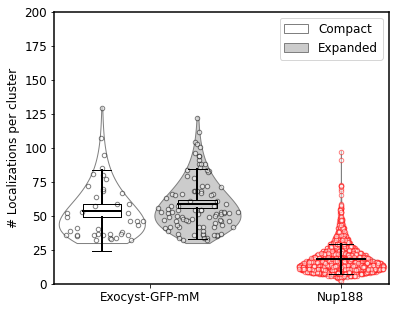

In [131]:
#print("%10s \tDistal %16s %15s %12s"%("Set","N","Proximal","N"))
fig,ax = plt.subplots(1,1,figsize=(2*3,5))
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
makeplot(exp_params,["WT"],ax=ax)
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

y = locs_npc_2.copy()
denplot(y,xshift=(2.*(0+1)+.5),style=2,color='w',edgecolors='gray')

ax.bxp([dict({"med":y.mean(),
        "q1" :y.mean()-y.mean()/np.sqrt(len(y)),
        "q3" :y.mean()+y.mean()/np.sqrt(len(y)),
        "whislo": y.mean()-y.std(),
        "whishi" : y.mean()+y.std()})],
      positions=[(2.*(0+1)+.5)],showfliers=False, patch_artist=False,
    medianprops={"color":'.0','lw':2},widths=.5,zorder=3,whiskerprops={"lw":2})


ax.set_xticks(np.arange(.5,3.5*(0+1),2))
ax.set_ylim(0,200)
ax.set_xticklabels(["Exocyst-GFP-mM","Nup188"])
ax.set_ylabel("# Localizations per cluster")
ax.legend()
#plt.savefig("figs/Copy_Number_WT.svg")

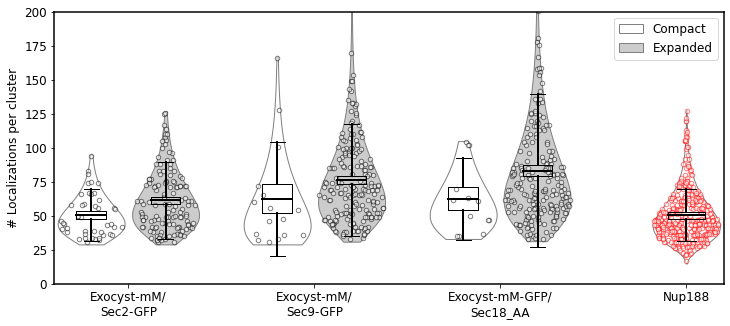

In [133]:
#print("%10s \tDistal %16s %15s %12s"%("Set","N","Proximal","N"))
fig,ax = plt.subplots(1,1,figsize=(4*3,5))
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
makeplot(exp_params,["Sec2_GFP","Sec9_GFP","Sec18_AA"],ax=ax)
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


y = locs_npc_3.copy()

denplot(y,xshift=(2.5*(2+1)+.5),style=2,color='w',edgecolors='gray')

ax.bxp([dict({"med":y.mean(),
        "q1" :y.mean()-y.mean()/np.sqrt(len(y)),
        "q3" :y.mean()+y.mean()/np.sqrt(len(y)),
        "whislo": y.mean()-y.std(),
        "whishi" : y.mean()+y.std()})],
      positions=[(2.5*(2+1)+.5)],showfliers=False, patch_artist=False,
    medianprops={"color":'.0','lw':2},widths=.5,zorder=3,whiskerprops={"lw":2})

ax.set_xticks(np.arange(.5,3.5*(2+1),2.5))
ax.set_xticklabels(["Exocyst-mM/\nSec2-GFP","Exocyst-mM/\nSec9-GFP","Exocyst-mM-GFP/\nSec18_AA","Nup188"])
ax.set_ylabel("# Localizations per cluster")
ax.set_ylim(0,200)
ax.legend()
plt.show()
#plt.savefig("figs/Copy_Number_Others.svg")

## Fig 2D-4A-5E : Compact-Expanded Populations

In [136]:
results = pd.read_csv("Results_over_replicates_using_fixed_Class_Oct11.csv.csv")
results = results.apply(pd.to_numeric,errors='ignore')
results = results.groupby("Set").mean()
results

,Distal,Proximal,STD,SEM,Count,N_replicates
Set,,,,,,
Control,0.1896,0.8104,0.0126,inf,276,1
Control_1,0.2277,0.7723,0.0265,0.0337,419,3
Sec18_AA,0.0573,0.9427,0.0128,0.0348,220,3
Sec2_GFP,0.2654,0.7346,0.0313,0.0601,173,3
Sec9_AA,0.2611,0.7389,0.0229,0.0740,253,3
Sec9_GFP,0.0898,0.9102,0.0187,0.0355,202,3
Sec9_WT,0.3590,0.6410,0.0291,inf,212,1
WT,0.3243,0.6757,0.0348,0.0767,136,3
WT_37C,0.0990,0.9010,0.0157,inf,193,1


WT 136


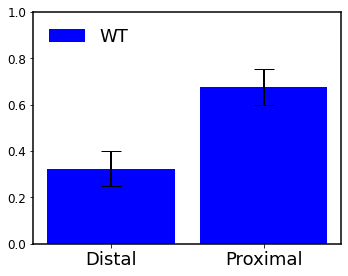

Sec2_GFP 173
Sec9_GFP 202


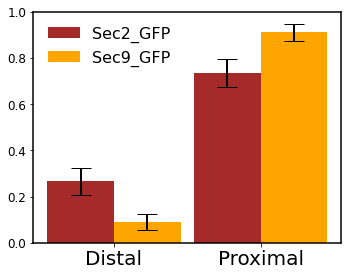

WT 136
Sec18_AA 220


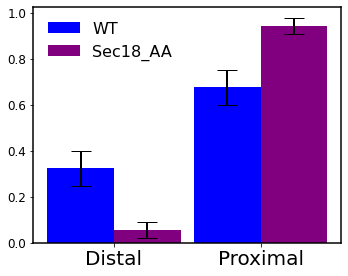

In [138]:
sets = ["WT"]
preds= ['Distal','Proximal']

rows = 1
cols = 1
fig,axes = plt.subplots(rows,cols,figsize=(cols*5,rows*4))

for i,ids in enumerate(sets):
    #sns.histplot(data=aux_params.query("Set == '%s'"%ids),x="Pred",hue="Set",stat='density',common_norm=False,bins=models)    
    print(ids,results.loc[ids,"Count"])
    ax = axes
    p      = { idm: results.loc[ids,idm] for idm in preds} 
    p_std  = { idm: results.loc[ids,"SEM"]  for idm in preds} 
    ax.bar( [i+1.2*j for j in range(len(preds))],[*p.values()],label=ids,color=colors[ids],width=1.)
    ax.errorbar([i+1.2*j for j in range(len(preds))],[*p.values()],[*p_std.values()],color='k',fmt='none',capsize=10,lw=2)

ax.set_xticks([0.+1.2*j for j in range(len(preds))],[*p.keys()],rotation=0,ha='center',fontsize=18)    
ax.set_yticks(np.arange(0,1.1,0.2),fontsize=18)
ax.legend(loc=2,fontsize=18,frameon=0)
ax.set_ylim(0,1)
plt.tight_layout()
#plt.savefig("figs/Distal_Prox_WT_%s.png"%method,dpi=80,transparent=False,facecolor='white')

plt.show()


sets = ["Sec2_GFP","Sec9_GFP"]

rows = 1
cols = 1
fig,axes = plt.subplots(rows,cols,figsize=(cols*5,rows*4))

for i,ids in enumerate(sets):
    #sns.histplot(data=aux_params.query("Set == '%s'"%ids),x="Pred",hue="Set",stat='density',common_norm=False,bins=models)    
    print(ids,results.loc[ids,"Count"])
    ax = axes
    p      = { idm: results.loc[ids,idm] for idm in preds} 
    p_std  = { idm: results.loc[ids,"SEM"]  for idm in preds}  
    ax.bar( [i+2.2*j for j in range(len(preds))],[*p.values()],label=ids,color=colors[ids],width=1)
    ax.errorbar([i+2.2*j for j in range(len(preds))],[*p.values()],[*p_std.values()],color='k',fmt='none',capsize=10,lw=2)

ax.set_xticks([0.5+2.2*j for j in range(len(preds))],[*p.keys()],rotation=0,ha='center',fontsize=20)    
ax.legend(loc=2,fontsize=16,frameon = 0)
ax.set_yticks(np.arange(0,1.1,0.2),fontsize=20)
ax.set_ylim(0,1)
plt.tight_layout()
#plt.savefig("figs/Distal_Prox_Sec2_Sec9_%s.png"%method,dpi=80,transparent=False,facecolor='white')

plt.show()
    

sets = ["WT","Sec18_AA"]

rows = 1
cols = 1
fig,axes = plt.subplots(rows,cols,figsize=(cols*5,rows*4))

for i,ids in enumerate(sets):
    #sns.histplot(data=aux_params.query("Set == '%s'"%ids),x="Pred",hue="Set",stat='density',common_norm=False,bins=models)    
    print(ids,results.loc[ids,"Count"])
    ax = axes
    p      = { idm: results.loc[ids,idm] for idm in preds} 
    p_std  = { idm: results.loc[ids,"SEM"]  for idm in preds}     
    ax.bar( [i+2.2*j for j in range(len(preds))],[*p.values()],label=ids,color=colors[ids],width=1)
    ax.errorbar([i+2.2*j for j in range(len(preds))],[*p.values()],[*p_std.values()],color='k',fmt='none',capsize=10,lw=2)

ax.set_xticks([0.5+2.2*j for j in range(len(preds))],[*p.keys()],rotation=0,ha='center',fontsize=20)    
ax.legend(loc=2,fontsize=16,facecolor=None,frameon=0)
ax.set_yticks(np.arange(0,1.1,0.2),fontsize=20)
plt.tight_layout()
#plt.savefig("figs/Distal_Prox_WT_Sec18AA_%s.png"%method,dpi=80,transparent=False,facecolor='white')

plt.show()


## Fig 2D-4A-5E-S7: Averaging & Ground Truth ExHOS radius

### Functions

In [194]:
def read_params(path):
    params_plus_fit   = pd.read_csv(path)
    #params_plus_fit   = params_plus_fit.drop("Covariance",axis=1)    
    centers = [] 
    for f in params_plus_fit.columns:
        if "_Center" in f:
            centers.append(f)
    
    for data in [params_plus_fit]:        
        for idc in centers:
            for id in data.index:
                x = data.loc[id,idc]
                x = x.replace('[',' ').replace(']',' ').replace(',',' ').split()        
                x = np.array(x).astype(float)  
                data.at[id,idc] = x
    return(params_plus_fit)

def rot_vect(v,theta):
    rot_Mat = np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
    vrot= rot_Mat.dot(v)
    return(vrot)

def regression(x,y,yo):
    return y(x)-yo

def filter_points(x,y,locp,dx=8):
    
    xs = []
    ys = [] 
    locps = []
    np.random.seed(3)
    ids = np.random.permutation(len(x))
    aux = ids.copy()
    xx = x[ids]
    yy = y[ids]
    lps= locp[ids]
    
    j = 0
    while (len(ids)>0) and (j<len(x)):
        i = ids[0]
        sel = (abs(xx-x[i])<dx)&(abs(yy-y[i])<dx)    
        #print(j,i,len(ids),np.sum(sel))        
        if np.sum(sel)>0:              
            w_i = 1/lps[sel]**2
            xs.append(np.sum(w_i*xx[sel])/np.sum(w_i))
            ys.append(np.sum(w_i*yy[sel])/np.sum(w_i))
            locps.append(1/np.sqrt(np.sum(w_i)))
        ids = ids[~sel]
        xx  = xx[~sel]
        yy  = yy[~sel]
        lps = lps[~sel]
        j += 1 
    
    return(np.stack((xs,ys),axis=1),np.array(locps))

def make_class_average(params,rand_rot=False): 
    
    if len(params) > 0:
        alldata  = np.array([[0,0]])
        all_GFP  = np.array([[0,0]])            
    else:
        print("Not data found")
        return(None) 
    #print(len(params))
    binsr = np.arange(0,105,5)
    dist  = np.zeros(len(binsr[:-1]))
    dist2 = np.zeros(len(binsr[:-1]))

    for j,id in enumerate(params.index):

        idf = params.loc[id,"File_ID_or"]
        ids = params.loc[id,"Site_ID"]
        n   = params.loc[id,"N_Locs"]
        
        wi  = weights[j]
        #print(id,j,idf,ids)
        
        data_or = np.loadtxt(
            '/home/jsortiz/phd/Beta-Fitting/Exp_Sites_Locs/File_Grouped_%d_Site_%d.txt'% (idf,ids))  
        lp      = data_or[:-2,2]
        data_or = data_or[:-2,:2]

        GFP_cx,GFP_cy  =  params.loc[id,["GFP_Center_X","GFP_Center_Y"]]  #GFP center    
        tau_cx,tau_cy  =  params.loc[id,["Tau_Center_X","Tau_Center_Y"]]  #Tau center    
        #lm_cx ,lm_cy   =  params.loc[id,["LM_Center_X","LM_Center_Y"]]   #LM center    
        #pcx   ,pcy     =  params.loc[id,"PCA_Center"]  #PCA center    
        #theta   =  params.loc[id,"PCA_Theta"]                 

        ## Fitting is done around Mass Center                                
        cx,cy       =  params.loc[id,["Mass_Center_X","Mass_Center_Y"]]    #Mass center                        
        #cx_dx,cy_dx =  params.loc[id,"Mass_Center_dx"] #Mass center with spatial filter                
        
        #dist    = np.linalg.norm(data_or- [cx,cy],axis=1)
        #data_or = data_or[dist<R]

        if do_aligned:                      
            data_T = data_or - [pcx,pcy]
            data_T = np.apply_along_axis(rot_vect,1,data_T,theta)
            data_T = data_T  + [pcx,pcy]
            data_or= data_T.copy()

        if do_center == "Fit_Center":
            fx,fy = params.loc[id,"Fit_Center"] ##Fit center                                                                      
            fx,fy = [fx+cx,fy+cy]
        elif do_center == "GFP_Center":
            fx,fy = [GFP_cx,GFP_cy]                
        elif do_center == "Mass_Center":
            fx,fy = [cx,cy]
        elif do_center == "Mass_Center_dx":
            fx,fy = [cx_dx,cy_dx]
        elif do_center == "Tau_Center":
            fx,fy = [tau_cx+cx,tau_cy+cy]
        elif do_center == "LM_Center":
            fx,fy = [lm_cx+cx,lm_cy+cy]
        else:
            fx,fy = [GFP_cx,GFP_cy]
            print("With GFP_Center")

        data_or =  data_or - [fx,fy]       
        
        den     = np.histogram(np.linalg.norm(data_or,axis=1),bins=binsr,density=True)[0]       
        #except:
        #    print(idf,ids)
        dist   +=  wi*den
        dist2  +=  wi*den**2
        
        if do_filter:
            data_or, lp = filter_points(x=data_or[:,0],y=data_or[:,1],locp=lp)
        
        if rand_rot:
            data_or = np.apply_along_axis(rot_vect,1,data_or,np.random.rand()*2*np.pi)           
  
        #all_theta.append(abs(theta))
        alldata = np.append(alldata,data_or,axis=0)                
        all_GFP = np.append(all_GFP,[[GFP_cx-cx,GFP_cy-cy]],axis=0)

        if plot_version == 2:                    

            hist,binsx,binsy=np.histogram2d(data_or[:,0],data_or[:,1],bins=np.arange(-150,151,3))                    
            imgi = gaussian_filter(hist, sigma=sigma/3)       
            imgi = imgi/len(data_or)                     

            if  j == 0:
                img = wi*imgi
            else:
                img += wi*imgi

    #dist=np.linalg.norm(alldata,axis=1)           

    if plot_version == 1:
        
        hist,binsx,binsy=np.histogram2d(alldata[:,0],alldata[:,1],bins=np.arange(-150,151,3))
        img = gaussian_filter(hist/len(params), sigma=sigma/3)

    elif plot_version == 2:

        #img = img/len(params)        
        img  = img
    else:
        print("Define plot version")
        
    return(img,dist,dist2,binsr)


### Run

agfa


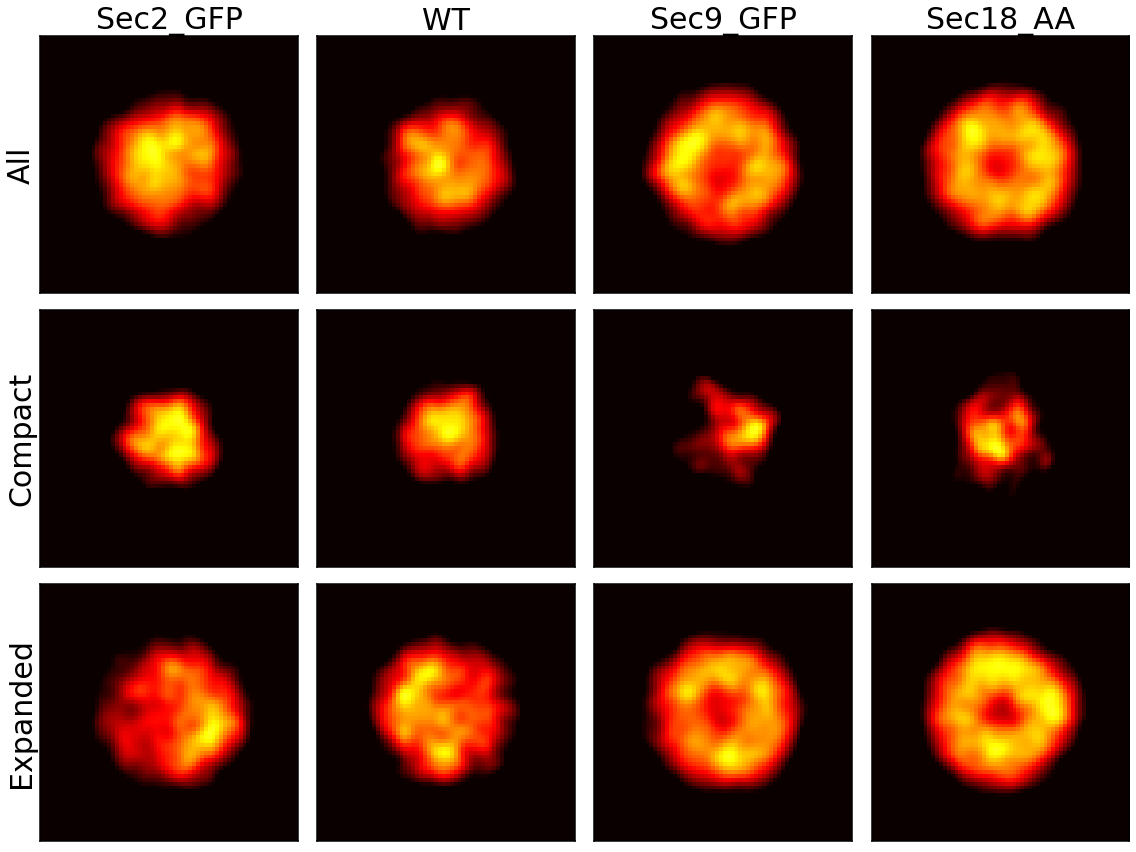

In [186]:
# %matplotlib inline 
#++++++++++++++++++++++++++++++++++#
#++Averaging the single SMLM+++++++#
#++cluster according to the++++++++#
#++Compact & Expanded classes++++++#

#  avg_img = sum_i wi*img_i
#  with wi = pij /sum_i pij, where pij is the Random Forest weight assigned to the
#  j-class (Compact or Expanded ) for the i-th image

sigma=8/np.sqrt(2)
drr=sigma // 2

rows,cols = [6,5]
maxf = 0
img  = [0]
plot_version = 2
all_theta = []

#params_plus_fit = params_plus_fit.query("R_Tau<60").copy()
preds = exp_params["Pred"].unique()
preds  = np.sort(preds)

den        = []
do_aligned = False
do_filter  = False
do_center  = "Tau_Center"
sets       = ["Sec2_GFP","WT","Sec9_GFP","Sec18_AA"]

cols = len(sets)
rows = 3

plt.figure(figsize=(cols*4,rows*4))

ref_img = np.loadtxt("Ref_Image.dat")

for i,ids in enumerate(sets):     
    for j,idc  in enumerate(["All","Compact","Expanded"]):        
        
        if idc != "All":
            
            aux_params = exp_params.query("Set == '%s' and Pred == '%s' and R_Tau<80" %(ids,idc)).copy()                
            nsites   = len(aux_params)
            weights  = aux_params[idc].values        
            weights /= np.sum(weights)                    
            
        else:
            aux_params = exp_params.query("Set == '%s' and R_Tau<80" %(ids)).copy()                
            nsites   = len(aux_params)
            weights  = np.ones(nsites)*1/nsites
        
        if len(aux_params) == 0:
            continue
            
        img,dist,dist2,r = make_class_average(aux_params,rand_rot=False) 
        r     = r[:-1]+np.diff(r)[0]/2
        dist2 = np.sqrt(dist2-dist**2)
        
        nrots = 1  
        if nrots>0:
            img *= 0.
            for k in range(nrots):              
                img += make_class_average(aux_params.sample(int(0.9*len(aux_params))),rand_rot=True)[0]        
            img = img/(nrots)
        
        plt.subplot(rows,cols,j*cols+i+1)        

        #plt.title(l)
        plt.imshow(img,cmap= 'hot',vmin=0.3*np.max(img),vmax= 1.2*np.max(img),
                   extent=(-150,150,-150,150))        

        plt.xticks([])
        plt.yticks([])              
        plt.xlim(-100,100)
        plt.ylim(-100,100)
            
        if i == 0: #and idl == 0:
            plt.ylabel("%s"%idc,fontsize=30,color='k')            
        if j == 0:
            plt.title(ids,fontsize=30,color='k')        
            
        alpha = 1. if idc=="Ring" else 1/2
        th = np.linspace(0,1,50)*2*np.pi
        
        rv = np.sqrt(1/alpha*aux_params["R_2nd"].mean()**2-2*15**2*1/alpha)
        x  = rv*np.cos(th) 
        y  = rv*np.sin(th) 
        #plt.plot(x,y,'--',alpha=0.2)
        #print("%.2f %.4f"%(stats.pearsonr(alldata[:,0],alldata[:,1])))
        #den.append([idc,l,(img[len(img)//2]+img[:,len(img)//2])/2])
        #r = np.arange(0,100,5)+2.5    
        img  = img/np.sum(img)      
        
        den.append([idc,ids,dist,dist2,nsites])                

#plt.box(False)
plt.tight_layout()

#plt.savefig("figs/Average_%s.png" %method,transparent=True
  #          , facecolor='w',bbox_inches='tight',dpi=200)  
print("agfa")

     Set     Mean radius (nm)    Ground Truth (nm)
  Sec2_GFP        All 28.9 +- 19.7 --> 32.6
  Sec2_GFP    Compact 20.6 +- 15.1 --> 19.5
  Sec2_GFP   Expanded 32.9 +- 20.3 --> 36.9
        WT        All 26.9 +- 18.9 --> 30.1
        WT    Compact 20.7 +- 15.7 --> 19.7
        WT   Expanded 30.9 +- 19.8 --> 34.7
  Sec9_GFP        All 33.1 +- 19.8 --> 37.2
  Sec9_GFP    Compact 22.8 +- 16.8 --> 23.7
  Sec9_GFP   Expanded 34.6 +- 19.7 --> 39.0
  Sec18_AA        All 33.3 +- 19.3 --> 37.4
  Sec18_AA    Compact 21.2 +- 15.5 --> 21.3
  Sec18_AA   Expanded 34.8 +- 19.2 --> 39.2
   WT_Corr   Proximal 34.8 +- 19.2 --> 39.2 ---


/home/jsortiz/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/jsortiz/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/jsortiz/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/jsortiz/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


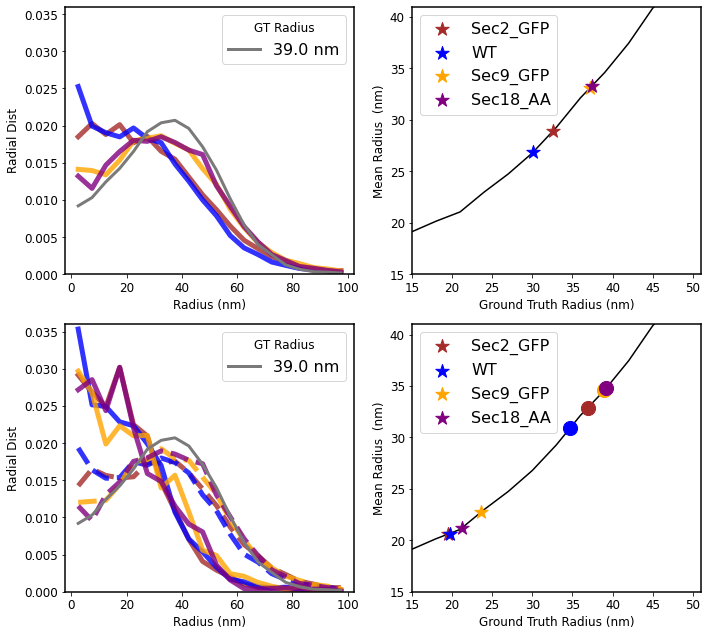

In [215]:
data = np.loadtxt("/home/jsortiz/theoretical_radial_distributions.dat")
meanr_theo = pd.read_csv("/home/jsortiz/Mean_Radius_Ground_Truth") 
fit   = interp1d(meanr_theo["Rv"],meanr_theo["Mean_Radius"],kind=1)

dr= np.diff(r)[0]
results = []
print("%8s %20s %20s"%("Set","Mean radius (nm)","Ground Truth (nm)"))
with mpl.rc_context({'text.usetex': False,"svg.fonttype": 'none'}):
    
    fig,axes = plt.subplots(2,2,figsize=(2*5,2*4.5))    
    axes     = np.ravel(axes)
    
    for y in den:
        
        pr = y[2]/(2*r*dr) 
        z  = np.sum(pr)*dr
        pr = pr/z
        
        idf = 0 if y[0] == "All" else 1

        ax  = axes[2*idf]
        ax.plot(r,pr,label=None,                     
                 color=colors[y[1]],lw=5,alpha=0.8,ls={"Compact":'-',"Expanded":'--',"All":'-'}[y[0]])            


        x = len(exp_params.query("File_ID>3 and Set == '%s'"%y[1]))

        rmean  = np.sum(r*pr)*dr
        rmean2 = np.sum(r*r*pr)*dr
        rstd   = np.sqrt(rmean2 - rmean**2)

        s = 15 # nm
        rv_pred = 1/4 *(2*rmean + np.sqrt(2)*s + np.sqrt((2*rmean + np.sqrt(2)*s)**2-16*s**2))               
        rv_pred = fsolve(regression,x0=40,args=(fit,rmean))
        #rmean = (rv + 15**2/rv)-15/np.sqrt(2)
        
        ax  = axes[2*idf+1]
        ax.scatter(rv_pred,rmean,color=colors[y[1]],
                        marker={"Compact":'*',"Expanded":'o',"All":'*'}[y[0]],s=200,
                        label={"Compact":y[1],"Expanded":None,"All":y[1]}[y[0]])
        results.append([y[1],y[0],y[-1],rmean,rstd,rv_pred])
        print("%10s %10s %.1f +- %.1f --> %.1f"%(y[1],y[0],rmean,rstd,rv_pred))
        #print("%10s %6d%6d %10.2f"  %(y[1],y[-1],x,y[-1]/x))
        #print("%10s %7.2f%7.2f%7.2f%7.2f"  %(y[1],xmin[y[1]],xmax[y[1]],ymin[y[1]],ymax[y[1]]))
        #lims.iloc[i]= (y[1],xmin[y[1]],xmax[y[1]],ymin[y[1]],ymax[y[1]])            
    
    x = np.arange(15,60,3)
    for i,rv in enumerate(x):
        if rv == 39:
            y  = data[i]             
            #r_tau  =  data["R_Tau"].mean()                
            axes[0].plot(r,y,color=sns.color_palette("Greys",4)[i//4],lw=3,label='%.1f nm'%rv)
            axes[2].plot(r,y,color=sns.color_palette("Greys",4)[i//4],lw=3,label='%.1f nm'%rv)
    axes[1].plot(meanr_theo["Rv"],meanr_theo["Mean_Radius"],'k-',zorder=-1)
    axes[3].plot(meanr_theo["Rv"],meanr_theo["Mean_Radius"],'k-',zorder=-1)
    
    """r_ref  = np.array(r_ref)
    rmean  = np.sum(r_ref*den_ref/np.sum(den_ref))
    rmean2 = np.sum(r_ref**2*den_ref/np.sum(den_ref))
    rstd   = np.sqrt(rmean2 - rmean**2)    
    print("%10s %.1f +- %.1f"%("Ref_R40",rmean,rstd))"""     

    print("%10s %10s %.1f +- %.1f --> %.1f ---"%("WT_Corr","Proximal",rmean,rstd,rv_pred))


    #plt.plot(r_ref,den_ref/np.sum(den_ref),'k--')
    for idf in [0,1]:

        axes[2*idf].legend(fontsize=16,title="GT Radius")
        axes[2*idf+1].legend(fontsize=16)
        #plt.yticks([])
        #plt.axvline(40,color='gray',ls='--',alpha=0.4)
        #axes[0].axvline(31.1,color='gray',ls='--',alpha=0.4)
        #axes[0].axvline(21.2,color='gray',ls='--',alpha=0.4)    
        axes[2*idf].set_ylim(0,0.036)
        axes[2*idf].set_xlabel("Radius (nm)")
        axes[2*idf].set_ylabel("Radial Dist")
        axes[2*idf+1].set_xlim(15,51)
        axes[2*idf+1].set_ylim(15,41)
        axes[2*idf+1].set_xlabel("Ground Truth Radius (nm)")
        axes[2*idf+1].set_ylabel("Mean Radius  (nm)")

    plt.tight_layout()
    #plt.savefig("figs/Radial_Dist_Average_GT_radius_%s.png" %method,dpi=80)    